# Homework 2: Predicting Housing Prices

In [31]:
import pandas  as pd
import numpy   as np
import seaborn as sns
import os
from subprocess import call, check_output
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

#call(['unzip','all.zip'])

os.listdir()

['test.csv.gz',
 'sample_submission.csv.gz',
 'test.csv',
 'data_description.txt',
 'all.zip',
 'train.csv',
 '.ipynb_checkpoints',
 'hw2.ipynb',
 'train.csv.gz',
 'sample_submission.csv']

## Data Cleaning

I'm going to read in both train and test. I will create my own train and test later.

In [32]:
train = pd.read_csv('train.csv')
test  = pd.read_csv('test.csv')
houses = pd.concat([train, test])

Here are some quick and messy looks at our data. This gives us an initial sense of the values in the data.

In [33]:
houses.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,NaN,3,1Fam,TA,No,706.0,0.0,...,WD,0,Pave,8,856.0,AllPub,0,2003,2003,2008
1,1262,0,0,NaN,3,1Fam,TA,Gd,978.0,0.0,...,WD,0,Pave,6,1262.0,AllPub,298,1976,1976,2007
2,920,866,0,NaN,3,1Fam,TA,Mn,486.0,0.0,...,WD,0,Pave,6,920.0,AllPub,0,2001,2002,2008
3,961,756,0,NaN,3,1Fam,Gd,No,216.0,0.0,...,WD,0,Pave,7,756.0,AllPub,0,1915,1970,2006
4,1145,1053,0,NaN,4,1Fam,TA,Av,655.0,0.0,...,WD,0,Pave,9,1145.0,AllPub,192,2000,2000,2008


In [34]:
houses.describe()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,...,OverallQual,PoolArea,SalePrice,ScreenPorch,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
count,2919.000000,2919.000000,2919.000000,2919.000000,2918.000000,2918.000000,2917.000000,2917.000000,2918.000000,2919.000000,...,2919.000000,2919.000000,1460.000000,2919.000000,2919.000000,2918.000000,2919.000000,2919.000000,2919.000000,2919.000000
mean,1159.581706,336.483727,2.602261,2.860226,441.423235,49.582248,0.429894,0.061364,560.772104,23.098321,...,6.089072,2.251799,180921.195890,16.062350,6.451524,1051.777587,93.709832,1971.312778,1984.264474,2007.792737
std,392.362079,428.701456,25.188169,0.822693,455.610826,169.205611,0.524736,0.245687,439.543659,64.244246,...,1.409947,35.663946,79442.502883,56.184365,1.569379,440.766258,126.526589,30.291442,20.894344,1.314964
min,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,34900.000000,0.000000,2.000000,0.000000,0.000000,1872.000000,1950.000000,2006.000000
25%,876.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,220.000000,0.000000,...,5.000000,0.000000,129975.000000,0.000000,5.000000,793.000000,0.000000,1953.500000,1965.000000,2007.000000
50%,1082.000000,0.000000,0.000000,3.000000,368.500000,0.000000,0.000000,0.000000,467.000000,0.000000,...,6.000000,0.000000,163000.000000,0.000000,6.000000,989.500000,0.000000,1973.000000,1993.000000,2008.000000
75%,1387.500000,704.000000,0.000000,3.000000,733.000000,0.000000,1.000000,0.000000,805.500000,0.000000,...,7.000000,0.000000,214000.000000,0.000000,7.000000,1302.000000,168.000000,2001.000000,2004.000000,2009.000000
max,5095.000000,2065.000000,508.000000,8.000000,5644.000000,1526.000000,3.000000,2.000000,2336.000000,1012.000000,...,10.000000,800.000000,755000.000000,576.000000,15.000000,6110.000000,1424.000000,2010.000000,2010.000000,2010.000000


### Missing Values

In [40]:
print('observations', houses.shape[0], '\n')

def missing_values(df):
    missingDict = {}
    for var in df.columns:
        missingDict[var] = df[df[var].isnull()].shape[0]

    return pd.Series(missingDict).sort_values(ascending=False)

missing_values(houses)

observations 2919 



PoolQC           2909
MiscFeature      2814
Alley            2721
Fence            2348
SalePrice        1459
FireplaceQu      1420
LotFrontage       486
GarageFinish      159
GarageCond        159
GarageQual        159
GarageYrBlt       159
GarageType        157
BsmtCond           82
BsmtExposure       82
BsmtQual           81
BsmtFinType2       80
BsmtFinType1       79
MasVnrType         24
MasVnrArea         23
MSZoning            4
BsmtFullBath        2
BsmtHalfBath        2
Utilities           2
Functional          2
Electrical          1
Exterior2nd         1
KitchenQual         1
Exterior1st         1
GarageCars          1
TotalBsmtSF         1
                 ... 
Neighborhood        0
YearBuilt           0
WoodDeckSF          0
TotRmsAbvGrd        0
Street              0
ScreenPorch         0
SaleCondition       0
RoofStyle           0
RoofMatl            0
PoolArea            0
PavedDrive          0
OverallQual         0
OverallCond         0
OpenPorchSF         0
MoSold    

There are quite a few missing values. Luckily, data_description.txt states what some of those values should be.

In [41]:
NA_variables = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu',\
                'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']
for var in NA_variables:
    houses.loc[houses[var].isnull(),var] = 'None' #All of them indicate that the specific element of the house is missing.
    
missing_values(houses)

SalePrice        1459
LotFrontage       486
GarageYrBlt       159
MasVnrType         24
MasVnrArea         23
MSZoning            4
Utilities           2
Functional          2
BsmtHalfBath        2
BsmtFullBath        2
KitchenQual         1
Electrical          1
Exterior1st         1
Exterior2nd         1
BsmtUnfSF           1
BsmtFinSF2          1
BsmtFinSF1          1
SaleType            1
GarageArea          1
TotalBsmtSF         1
GarageCars          1
FireplaceQu         0
ExterCond           0
Fence               0
Fireplaces          0
Foundation          0
ExterQual           0
FullBath            0
YrSold              0
Condition1          0
                 ... 
PavedDrive          0
PoolArea            0
PoolQC              0
RoofStyle           0
MoSold              0
SaleCondition       0
ScreenPorch         0
Street              0
TotRmsAbvGrd        0
WoodDeckSF          0
YearBuilt           0
Neighborhood        0
MiscVal             0
GarageType          0
KitchenAbv

It looks like that fixed a lot of the missing values. However, there are still some other missing values that we need to deal with. Some of these are numerical variables of elements that we fixed above, so we'll first code those as zero.

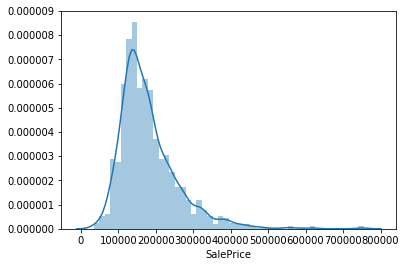

In [7]:
sns.distplot(train.SalePrice, bins=50)

In [9]:
#print(train[train.LotFrontage == 0])
#train[train.LotFrontage.isnull()] = 0.0

In [10]:
scaler = StandardScaler()
scaler.fit(train)
scaler_train = scaler.transform(train)

ValueError: could not convert string to float: 'Normal'